# Modelling poisson using PINN

Solving the poisson equation $-\Delta u = f$ using a physics informed neural network 

## 1D problem

### Manufactured solution


We use $u = x^3$ for $x\in [0,4]$ to manufacture the right hand side to be $f=6x$

### Importing packages

In [103]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Manufacturing data for trainig

In [218]:
np.random.seed(123)
X_tr_pde = np.random.uniform(0,3,5000).reshape(5000,1)


#### Plotting histogram of randomly selected points to make sure they are uniformly distributed 

Text(0, 0.5, 'frequency ')

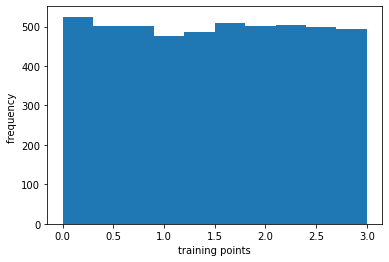

In [219]:
plt.hist(X_tr_pde)
plt.xlabel("training points")
plt.ylabel("frequency ")

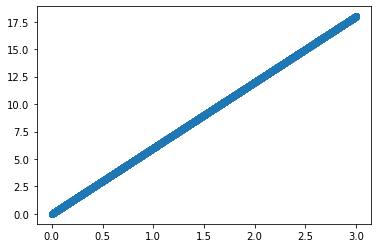

In [220]:
Y_tr_pde = 6*X_tr_pde
plt.scatter(X_tr_pde,Y_tr_pde)

In [221]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((X_tr_pde.size,1))],axis=1)
Y_tr_pde.shape

(5000, 2)

In [222]:
X_tr_Dr_bc_left = np.zeros(100).reshape(100,1)
X_tr_Dr_bc_right = 3*np.ones(100).reshape(100,1)
X_bc = np.concatenate([X_tr_Dr_bc_left,X_tr_Dr_bc_right],axis=0)

Y_tr_Dr_bc_left = X_tr_Dr_bc_left**3
Y_tr_Dr_bc_right = X_tr_Dr_bc_right**3
Y_tr_bc = np.concatenate([Y_tr_Dr_bc_left,Y_tr_Dr_bc_right],axis=0)
Y_tr_bc = np.concatenate([Y_tr_bc,np.ones((200,1))],axis=1)
Y_tr_bc

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,

In [223]:
X_tr = np.concatenate((X_tr_pde, X_bc), axis=0)
Y_tr = np.concatenate((Y_tr_pde, Y_tr_bc), axis=0)

In [224]:
Y_tr

array([[12.53644534,  0.        ],
       [ 5.15050803,  0.        ],
       [ 4.08332616,  0.        ],
       ...,
       [27.        ,  1.        ],
       [27.        ,  1.        ],
       [27.        ,  1.        ]])

## Training the model

In [225]:
from tensorflow.keras import backend as K
class CustomModel(tf.keras.Model):

    def __init__(self):
        super(CustomModel, self).__init__()
        self.dense_1 = keras.layers.Dense(30, activation="elu",
                                          name="dense_1")
        self.dense_2 = keras.layers.Dense(30, activation="elu",
                                         name="dense_2")
        self.dense_3 = keras.layers.Dense(1,
                                         name="dense_3")

    def findGrad(self, f_derrivative, input_arg):
        return keras.layers.Lambda(lambda z: K.gradients(z[0],z[1])[0]) ([f_derrivative, input_arg])
    
    def findPdeLayer(self, pde_lhs, input_arg):
        return keras.layers.Lambda(lambda z: z[0] - 6*z[1]) ([pde_lhs, input_arg])
    
    def call(self, inputs):
        layer_1 = self.dense_1(inputs)
        layer_2 = self.dense_2(layer_1)
        layer_3 = self.dense_3(layer_2)
        
        grad_layer = self.findGrad(layer_3, inputs)
        laplace_layer = self.findGrad(grad_layer, inputs)
        pde_layer = self.findPdeLayer(laplace_layer, inputs)
        
        return layer_3, pde_layer



In [226]:
custom_model = CustomModel()

In [227]:
X_test_st = np.random.uniform(0,2,20).reshape((20,1))
Y_test = custom_model.predict(X_test_st)

In [228]:
#Loss coming from the boundary terms
def u_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
    return tf.where(at_boundary, u_sq_error, 0.)

#Loss coming from the PDE constrain
def pde_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    #need to change this to just tf.square(y_pred) after pde constrain is added to grad_layer
    pde_sq_error = (1/2)*tf.square(y_pred)
    return tf.where(at_boundary,0.,pde_sq_error)

In [229]:
custom_model.compile(loss=[u_loss,pde_loss], optimizer="nadam")

In [230]:
custom_model.fit(x=X_tr, y=Y_tr,epochs=20)

Epoch 1/20
163/163 [==============================] - 1s 7ms/step - loss: 52.6611 - output_1_loss: 7.0178 - output_2_loss: 45.6433
Epoch 2/20
163/163 [==============================] - 1s 4ms/step - loss: 33.7969 - output_1_loss: 4.3327 - output_2_loss: 29.4642
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 20.2773 - output_1_loss: 3.2770 - output_2_loss: 17.0002
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 12.1600 - output_1_loss: 3.2010 - output_2_loss: 8.9590
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 6.2403 - output_1_loss: 2.0411 - output_2_loss: 4.1992
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 3.2332 - output_1_loss: 1.0658 - output_2_loss: 2.1673
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 2.3336 - output_1_loss: 0.4667 - output_2_loss: 1.8669
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 1.6516 - output_

In [232]:
custom_model.compile(loss=[u_loss,pde_loss], optimizer=keras.optimizers.SGD(lr=1e-3))
custom_model.fit(x=X_tr, y=Y_tr,epochs=20)

Epoch 1/20
163/163 [==============================] - 1s 4ms/step - loss: 1.0126 - output_1_loss: 0.1165 - output_2_loss: 0.8961
Epoch 2/20
163/163 [==============================] - 1s 4ms/step - loss: 1.0596 - output_1_loss: 0.1405 - output_2_loss: 0.9190
Epoch 3/20
163/163 [==============================] - 1s 4ms/step - loss: 1.1486 - output_1_loss: 0.1735 - output_2_loss: 0.9751
Epoch 4/20
163/163 [==============================] - 1s 4ms/step - loss: 0.7193 - output_1_loss: 0.1048 - output_2_loss: 0.6145
Epoch 5/20
163/163 [==============================] - 1s 4ms/step - loss: 1.2582 - output_1_loss: 0.2113 - output_2_loss: 1.0470
Epoch 6/20
163/163 [==============================] - 1s 8ms/step - loss: 1.3331 - output_1_loss: 0.2217 - output_2_loss: 1.1114
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 0.8710 - output_1_loss: 0.1378 - output_2_loss: 0.7332
Epoch 8/20
163/163 [==============================] - 1s 4ms/step - loss: 0.8987 - output_1_loss:

In [233]:
X_test_st = np.random.uniform(0,3,50).reshape((50,1))

In [234]:
Y_test = custom_model.predict(X_test_st)

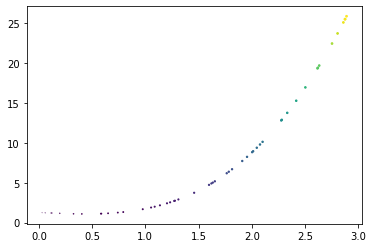

In [243]:
plt.scatter(X_test_st, Y_test[0][:,0], X_test_st, X_test_st**3)

In [ ]:
plt.scatter(X_test_st, X_tes_)